## Load and reduce galaxy catalog

The initial (NED Local Volume Sample) catalog is available at the following url: https://ned.ipac.caltech.edu/NED::LVS/

A reduced version for galaxies closer than 150 Mpc, with duplicate entries (within 5 arcsec) removed, is available in this folder: https://drive.google.com/drive/folders/1M0o6B6UKuB0DE3b9mooW9IulC_U0rGev

The BG field list, the BGLT field selection and the HECATE catalog restricted to galaxies closer than 180 Mpc are available in the same folder.

In [49]:
from astropy.table import Table
import pandas as pd
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import astropy.units as u
from astropy.wcs import WCS
import json

datadir = "Downloads/Catalogs/"

In [31]:
lvs = Table.read(datadir+"LVS_150.fits")
hec = Table.read(datadir+"HECATE_180.fits")

In [32]:
c1 = SkyCoord(lvs['ra'],lvs['dec'],frame='icrs',unit='deg')
c2 = SkyCoord(hec['RA'],hec['DEC'],frame='icrs',unit='deg')

# Match LVS and HECATE
idx,d2d,d3d = c1.match_to_catalog_sky(c2)

# Matching radius = 5 arcsec
ind = d2d.arcsec<5
idxind = idx[ind]

print(np.sum(ind), "LVS galaxies have a match in HECATE")

118206 LVS galaxies have a match in HECATE


* For galaxies with no SFR_hybrid, use SFR_W4
* For galaxies with no SFR or stellar mass, use HECATE values

In [27]:
mstar_missing = lvs['Mstar'].mask
print(np.sum(mstar_missing),"LVS galaxies with no Mstar")

sfr_missing = lvs['SFR_hybrid'].mask

# For galaxies with no SFR_hybrid, use SFR_W4
lvs['SFR_hybrid'][sfr_missing] = lvs['SFR_W4'][sfr_missing]

sfr_missing = lvs['SFR_hybrid'].mask
print(np.sum(sfr_missing),"LVS galaxies with no SFR")

# For galaxies with no SFR or stellar mass, use HECATE values
mstar_missing = np.logical_and(ind, mstar_missing)
sfr_missing = np.logical_and(ind, sfr_missing)

lvs['SFR_hybrid'][sfr_missing] = 10**hec['logSFR_HEC'][idx[sfr_missing]]
lvs['Mstar'][mstar_missing] = 10**hec['logM_HEC'][idx[mstar_missing]]

mstar_missing = lvs['Mstar'].mask
sfr_missing = lvs['SFR_hybrid'].mask
print(np.sum(mstar_missing),"LVS galaxies with no Mstar after HECATE completion")
print(np.sum(sfr_missing),"LVS galaxies with no SFR after HECATE completion")

44125 LVS galaxies with no Mstar
44489 LVS galaxies with no SFR
34286 LVS galaxies with no Mstar after HECATE completion
34735 LVS galaxies with no SFR after HECATE completion


## Keep only galaxies with valid SFR or Mstar and apply cuts

In [41]:
lvs = lvs[lvs['Mstar']>1e4]
lvs = lvs[lvs['SFR_hybrid']>0]
lvs['sSFR'] = lvs['SFR_hybrid']/lvs['Mstar']

print(len(lvs),"galaxies in clean sample")

67637 galaxies in clean sample


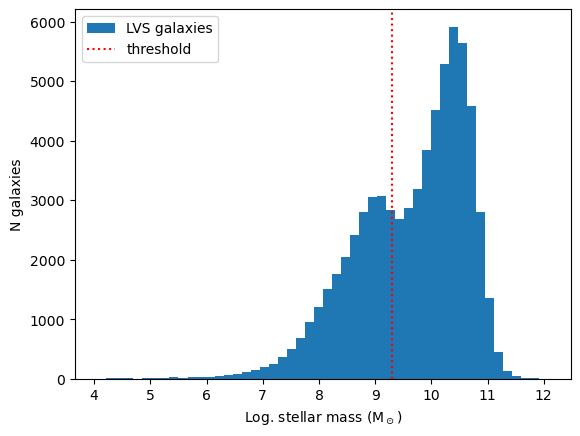

In [42]:
plt.hist(np.log10(lvs['Mstar']), bins=50, label='LVS galaxies')
plt.axvline(9.3, ls=':', color='r', label='threshold')
plt.xlabel("Log. stellar mass (M$_\odot$)")
plt.ylabel("N galaxies")
plt.legend()

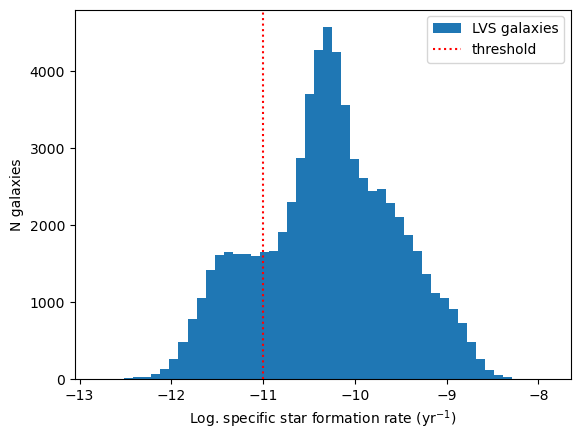

In [43]:
plt.hist(np.log10(lvs['sSFR']), bins=50, label='LVS galaxies')
plt.axvline(-11, ls=':', color='r', label='threshold')
plt.xlabel("Log. specific star formation rate (yr$^{-1}$)")
plt.ylabel("N galaxies")
plt.legend()

In [48]:
# apply cuts

lvs = lvs[np.logical_and(lvs['sSFR']>1e-11,lvs['Mstar']>2e9)]
lvs.write(datadir+"LVS_150_starforming.fits", overwrite=True)

print(len(lvs),"galaxies in massive starforming sample")

31369 galaxies in massive starforming sample


## Crossmatch with BlackGEM fields

The following function crossmatch the LVS galaxies positions to the coordinates of ML/BG fields.

A JSON file is generated to map each field to the corresponding LVS indexes

In [62]:
fields = pd.read_csv(datadir+"MLBG_FieldIDs_Oct2022.csv")
centers = SkyCoord(fields.ra.values*u.deg, fields.dec.values*u.deg, frame="icrs")
centers.transform_to(SkyOffsetFrame(origin=centers))

def coords2field(target, allfield = False):
    '''
    Returns the BlackGEM / MeerLICHT field IDS for a given position.

    Parameters
    ----------
    ra : float
        Right ascension of the position in degrees.
    dec : float
        Declination in degrees
        
    Returns
    -------
    fields : string or DataFrame
        The ID of the field(s) matching coordinates
    allfield: boolean
        Whether you want all fields matching coordinates or just one
    '''
    side = 1.64
    hside = side/2.
    
    
    target_centers = target.transform_to(SkyOffsetFrame(origin=centers))
    xi, eta = target_centers.lon, target_centers.lat

    contains_mask = (np.abs(xi) < hside*u.deg) * (np.abs(eta)< hside*u.deg)
        
    if allfield:
        return fields.iloc[contains_mask]['FieldID']
    else:
        return fields.iloc[contains_mask].iloc[0]['FieldID']


In [63]:
coo = SkyCoord(lvs['ra'], lvs['dec'],frame='icrs',unit='deg')
ra = coo.ra.deg
dec = coo.dec.deg

galids = {}
for i in tqdm(range(len(lvs))):
    fieldid_all = coords2field(coo[i],True)
    for j in range(len(fieldid_all)):
        f = int(fieldid_all.iloc[j])
        if f in galids.keys():
            galids[f].append(i)
            # new galaxy for the field, append to list
        else:
            galids[f] = [i]
            # first galaxy for the field, start a list



with open(datadir+"BGfields.json", "w") as outfile: 
    json.dump(galids, outfile)


100%|████████████████████████████████████████████████████████████████████████████| 31369/31369 [15:59<00:00, 32.69it/s]


In [56]:
galids

{11355: [0, 43],
 9573: [1],
 10698: [2],
 11138: [3, 8],
 3866: [4, 6, 45],
 12808: [5],
 8887: [7, 9, 11],
 7971: [10],
 7972: [10],
 8888: [11, 12],
 11570: [13],
 11571: [13, 18, 23, 39],
 6833: [14],
 9116: [15, 27, 34],
 10699: [16],
 1828: [17],
 6609: [19, 32],
 8200: [20, 30],
 9346: [21, 25, 33],
 9801: [22],
 6164: [24],
 14603: [26],
 14604: [26, 46, 101, 102],
 7286: [28, 36],
 952: [29],
 4461: [31],
 1975: [35, 96],
 12202: [37],
 4259: [38],
 4062: [40],
 11139: [41, 52],
 5081: [42],
 2771: [44, 57],
 9574: [47, 48, 55],
 9117: [49, 51, 63],
 13933: [50, 92],
 7743: [53, 73],
 5294: [54],
 849: [56],
 11356: [58],
 13005: [59, 79],
 12203: [60, 61],
 6834: [62],
 11784: [64, 66],
 6386: [65],
 11995: [67, 71, 76],
 3303: [68],
 1061: [69],
 1177: [69],
 2280: [70, 77, 81, 91],
 8201: [72],
 12610: [74, 93],
 7287: [75, 78],
 11996: [76, 90, 109],
 1296: [80],
 7061: [82],
 5295: [83],
 6610: [84, 85],
 3675: [86],
 3676: [86],
 9347: [87],
 953: [88, 95],
 11572: [89],

In [108]:
fields = pd.read_csv(datadir+"MLBG_FieldIDs_Oct2022.csv")
mstar = np.zeros(len(fields))
sfrs =  np.zeros(len(fields))

with open(datadir+'BGfields.json') as json_file:
    galids = json.load(json_file)

for i in tqdm(range(len(mstar))):
    f = str(fields['FieldID'][i])
    if f in galids.keys():
        mstar[i] = np.nansum(lvs['Mstar'][galids[f],])
        sfrs[i] = np.nansum(lvs['SFR_hybrid'][galids[f],])

        
fields['mtot'] = mstar
fields['sfrtot'] = sfrs

bglt_orig = pd.read_csv(datadir+"BGLT2_FieldIDs.dat") # original BGLT fields
i_orig = np.isin(fields['FieldID'],bglt_orig['col1'])
fields['BGLT_orig'] =  i_orig

100%|███████████████████████████████████████████████████████████████████████████| 16080/16080 [00:17<00:00, 916.61it/s]


In [109]:
#Southern sky
isouth = fields['dec']<30
fields_south = fields.loc[isouth]
sfrs = sfrs[isouth]
mstar = mstar[isouth]
i_orig = i_orig[isouth]

In [110]:
# Define threshold
sfr_min = 15
ind = sfrs>sfr_min
fields_south['selected'] = ind

print(np.sum(ind), "fields are selected for having cumulative SFR > %.1f M$_\odot$/yr"%sfr_min)

fields_south.to_csv(datadir+"BGLT_fields_SFR_0624.csv")

174 fields are selected for having cumulative SFR > 15.0 M$_\odot$/yr


C:\Users\hgtra\AppData\Local\Temp\ipykernel_3676\154890773.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fields_south['selected'] = ind


C:\Users\hgtra\AppData\Local\Temp\ipykernel_3676\1526549084.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(mstar[i_orig]),bins=np.linspace(8,13,50),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
C:\Users\hgtra\AppData\Local\Temp\ipykernel_3676\1526549084.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(sfrs[i_orig]),bins=np.linspace(-1.5,4,80),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)


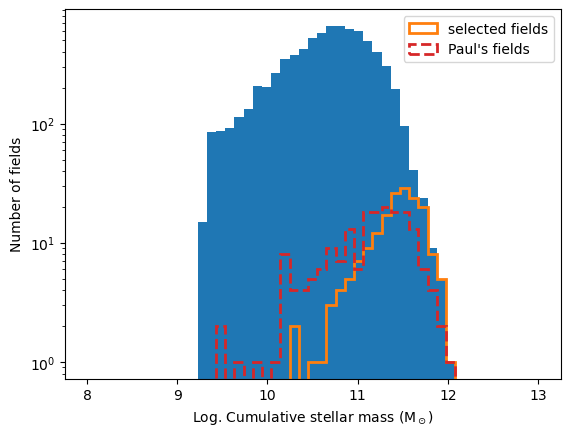

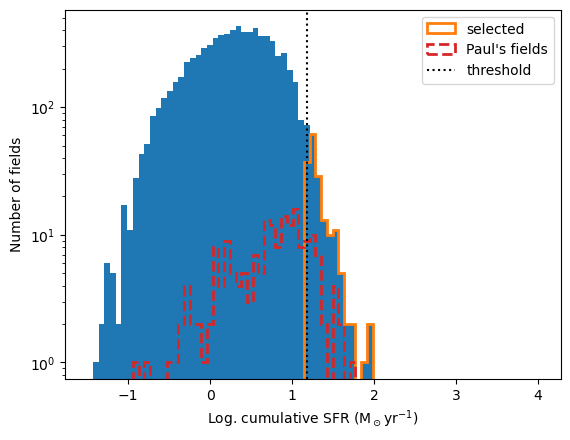

In [113]:
plt.figure()

plt.hist(np.log10(mstar[mstar>0]),bins=np.linspace(8,13,50))
plt.hist(np.log10(mstar[ind]),bins=np.linspace(8,13,50),histtype='step',label="selected fields",lw=2)
plt.hist(np.log10(mstar[i_orig]),bins=np.linspace(8,13,50),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
plt.legend()
plt.ylabel("Number of fields")
plt.xlabel("Log. Cumulative stellar mass $\mathrm{(M_\odot)}$")
plt.gca().set_yscale('log')


plt.figure()
plt.hist(np.log10(sfrs[sfrs>0]),bins=np.linspace(-1.5,4,80))
plt.hist(np.log10(sfrs[ind]),bins=np.linspace(-1.5,4,80),histtype='step',label='selected',lw=2)
plt.hist(np.log10(sfrs[i_orig]),bins=np.linspace(-1.5,4,80),histtype='step',label="Paul's fields",color='C3',ls='--',lw=2)
plt.axvline(np.log10(sfr_min),color='k',ls=':',label='threshold')
plt.legend()
plt.xlabel("Log. cumulative SFR ($\mathrm{M_\odot yr^{-1}}$)")
plt.ylabel("Number of fields")
plt.gca().set_yscale('log')

In [106]:
frac = np.sum(fields_south['sfrtot'].loc[fields_south['selected']])/np.sum(fields_south['sfrtot'])
print("selection covers %.2f percents of local star formation rate"%(frac*100))

selection covers 14.94 percents of local star formation rate


In [107]:
print(np.sum(np.logical_and(fields_south['selected'],fields_south['BGLT_orig'])),"fields in common with Paul's selection")

32 fields in common with Paul's selection


In [96]:
fields_south.iloc[np.argsort(fields_south['sfrtot'])[::-1]]

,FieldID,ra,dec,mtot,sfrtot,BGLT_orig,selected
11919,11920,234.59715,24.10432,2.119799e+11,94.410740,False,True
11918,11919,232.89099,24.10432,1.116072e+11,92.028808,False,True
1389,1390,272.16000,-57.73602,1.703092e+11,76.469563,False,True
12195,12196,349.61539,25.67818,3.841897e+11,58.282774,False,True
9793,9794,351.27753,8.36580,3.839673e+11,50.475653,True,True
...,...,...,...,...,...,...,...
6221,6222,95.67567,-15.24200,0.000000e+00,0.000000,False,False
6222,6223,97.29729,-15.24200,0.000000e+00,0.000000,False,False
6223,6224,98.91891,-15.24200,0.000000e+00,0.000000,False,False
6224,6225,100.54054,-15.24200,0.000000e+00,0.000000,False,False


Image of field with maximum sfr_tot:

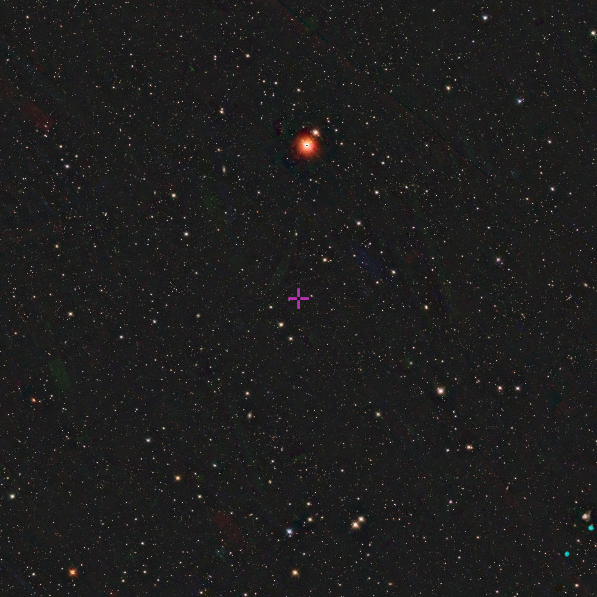

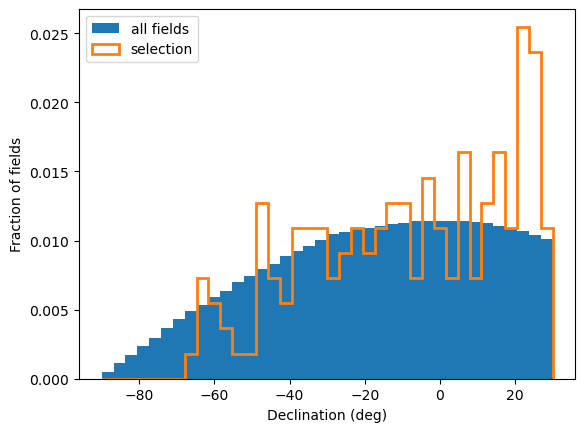

In [101]:
plt.hist(fields_south['dec'],bins=np.linspace(-90,30,39),density=True,label="all fields")
plt.hist(fields_south['dec'].loc[fields_south['selected']],bins=np.linspace(-90,30,39),histtype='step',lw=2,density=True,label="selection")
plt.ylabel("Fraction of fields")
plt.xlabel("Declination (deg)")
plt.legend()